- The goal of this notebook is to build a model that predicts which tweets are about real disasters and which ones aren't

# Loading libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import sklearn 
import nltk
import re
import string
import seaborn as sns
import xgboost
import catboost
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F     
import tensorflow as tf

2023-01-25 05:42:47.031834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# import packages from libraries
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

In [3]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


False

In [4]:
# ignore warnings
warnings.filterwarnings('ignore')

# Loading data

In [5]:
df = pd.read_csv('/Users/alijanatiidr/Desktop/Prog/Projects/Disaster_tweets_classification/data.csv')

In [6]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df.loc[df['target'] == 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


# Exploring data

In [8]:
# check the columns, their types and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
# drop irrelevant columns
del df['id']
del df['keyword']
del df['location']
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot: >

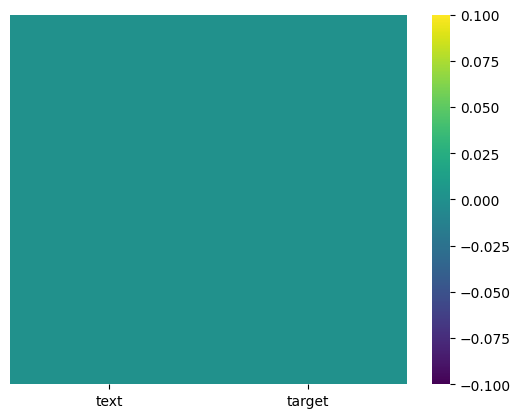

In [10]:
# plot missing data as a heatmap
sns.heatmap(df.isnull(), yticklabels = False, cmap= 'viridis')

In [11]:
# plot the distribution of the target variable in a pie chart
fig = go.Figure(data=[go.Pie(labels=['Not a disaster', 'Disaster'], values=df['target'].value_counts())])
fig.update_layout(title_text='Distribution of the target variable')
fig.show()

# Preparing data

# Implementing helpers functions

In [12]:
# Create a function that processes the tweets by removing stopwords, removing urls, lowercasing, tokenizing and stemming them
def process_tweet(tweet):
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    # remove urls
    tweet = re.sub(r"http\S+", "", tweet)
    # remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # lowercase
    tweet = tweet.lower()
    # tokenize
    tweet = tweet.split()
    # stem
    ps = nltk.PorterStemmer()
    tweet = [ps.stem(word) for word in tweet]
    tweet = ' '.join(tweet)
    return tweet

In [13]:
# testing the function with a random tweet
process_tweet('I am a student at the University of Tehran')

'i student univers tehran'

In [14]:
# creating function that creates a dictionary of words and their frequencies depending on the target variable
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [15]:
# creating frequency dictionary for the train set
freqs = build_freqs(df['text'], df['target'])

In [16]:
# creating a function that extracts features from the tweets
def extract_features(tweet, freqs):
    word_l = process_tweet(tweet)
    x = np.zeros((1, 3))
    x[0,0] = 1 # bias term
    for word in word_l:
        x[0,1] += freqs.get((word, 1.0), 0) # count of positive words
        x[0,2] += freqs.get((word, 0.0), 0) # count of negative words
    assert(x.shape == (1, 3))
    return x

In [17]:
# testing the function with a random tweet
extract_features('I am a student at the University of Tehran', freqs)

array([[1.00000e+00, 3.37093e+05, 4.01132e+05]])

# Parsing data

In [18]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=42)

In [19]:
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['target'], random_state=42)

In [20]:
freqs = build_freqs(train_df['text'], train_df['target'])

In [21]:
# vectorizing tweets using the frequency dictionary for the train set
processed_X_train = [process_tweet(tweet) for tweet in train_df['text']]
X_vectors = np.zeros((len(processed_X_train), 3))
for i in range(len(processed_X_train)):
    for word in processed_X_train[i]:
        X_vectors[i, 0] = 1 # bias term
        X_vectors[i, 1] += freqs.get((word, 1), 0)
        X_vectors[i, 2] += freqs.get((word, 0), 0)

x_train = X_vectors
y_train = train_df['target']

# vectorizing tweets using the frequency dictionary for the validation set
processed_X_val = [process_tweet(tweet) for tweet in val_df['text']]
X_vectors = np.zeros((len(processed_X_val), 3))
for i in range(len(processed_X_val)):
    for word in processed_X_val[i]:
        X_vectors[i, 0] = 1 # bias term
        X_vectors[i, 1] += freqs.get((word, 1), 0)
        X_vectors[i, 2] += freqs.get((word, 0), 0)

x_val = X_vectors
y_val = val_df['target']

# vectorizing tweets using the frequency dictionary for the test set
processed_X_test = [process_tweet(tweet) for tweet in test_df['text']]
X_vectors = np.zeros((len(processed_X_test), 3))
for i in range(len(processed_X_test)):
    for word in processed_X_test[i]:
        X_vectors[i, 0] = 1 # bias term
        X_vectors[i, 1] += freqs.get((word, 1), 0)
        X_vectors[i, 2] += freqs.get((word, 0), 0)

x_test = X_vectors
y_test = test_df['target']

In [22]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((6090, 3), (6090,), (762, 3), (762,), (761, 3), (761,))

# Modelizing

## Built in models

In [23]:
# Model 1: Scikit-learn's Logistic Regression
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

# Model 2: Scikit-learn's Naive Bayes
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

# Model 3: Scikit-learn's SVM
svm = SVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

# Model 4: Scikit-learn's Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

# Model 5: Scikit-learn's Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)

# Model 6: Scikit-learn's XGBoost
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

# Model 8: Scikit-learn's CatBoost
cb = CatBoostClassifier()
cb.fit(x_train, y_train)
y_pred = cb.predict(x_test)

# compute the accuracy of the models on the validation set in a dataframe
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost']
accuracies = [accuracy_score(y_val, lr.predict(x_val)), accuracy_score(y_val, nb.predict(x_val)), accuracy_score(y_val, svm.predict(x_val)), accuracy_score(y_val, rf.predict(x_val)), accuracy_score(y_val, gb.predict(x_val)), accuracy_score(y_val, xgb.predict(x_val)), accuracy_score(y_val, cb.predict(x_val))]
pd.DataFrame({'Model': models, 'Accuracy': accuracies})

Learning rate set to 0.022283
0:	learn: 0.6920307	total: 56.8ms	remaining: 56.8s
1:	learn: 0.6909109	total: 58.4ms	remaining: 29.2s
2:	learn: 0.6898629	total: 59.9ms	remaining: 19.9s
3:	learn: 0.6888039	total: 61.4ms	remaining: 15.3s
4:	learn: 0.6879212	total: 62.4ms	remaining: 12.4s
5:	learn: 0.6870309	total: 63.8ms	remaining: 10.6s
6:	learn: 0.6860919	total: 65.3ms	remaining: 9.26s
7:	learn: 0.6852368	total: 66.7ms	remaining: 8.27s
8:	learn: 0.6843786	total: 68.2ms	remaining: 7.51s
9:	learn: 0.6835380	total: 69.7ms	remaining: 6.89s
10:	learn: 0.6827604	total: 71.1ms	remaining: 6.39s
11:	learn: 0.6819757	total: 72.7ms	remaining: 5.99s
12:	learn: 0.6812957	total: 74.2ms	remaining: 5.64s
13:	learn: 0.6806722	total: 75.6ms	remaining: 5.33s
14:	learn: 0.6800032	total: 77ms	remaining: 5.06s
15:	learn: 0.6793432	total: 78.5ms	remaining: 4.83s
16:	learn: 0.6786325	total: 80ms	remaining: 4.63s
17:	learn: 0.6781349	total: 80.9ms	remaining: 4.41s
18:	learn: 0.6775114	total: 82.3ms	remaining: 4.

,Model,Accuracy
0,Logistic Regression,0.642576
1,Naive Bayes,0.621551
2,SVM,0.570302
3,Random Forest,0.642576
4,Gradient Boosting,0.624179
5,XGBoost,0.630749
6,CatBoost,0.634691


In [24]:
# logistic regression grid search, computing accuracy on validation set without cross-validation
lr = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['none', 'l2']}
for params in ParameterGrid(param_grid):
    lr.set_params(**params)
    lr.fit(x_train, y_train)
    print('Accuracy on validation set: {:.4f} for {}'.format(accuracy_score(y_val, lr.predict(x_val)), params))

Accuracy on validation set: 0.6426 for {'C': 0.001, 'penalty': 'none'}
Accuracy on validation set: 0.6426 for {'C': 0.001, 'penalty': 'l2'}
Accuracy on validation set: 0.6426 for {'C': 0.01, 'penalty': 'none'}
Accuracy on validation set: 0.6426 for {'C': 0.01, 'penalty': 'l2'}
Accuracy on validation set: 0.6426 for {'C': 0.1, 'penalty': 'none'}
Accuracy on validation set: 0.6426 for {'C': 0.1, 'penalty': 'l2'}
Accuracy on validation set: 0.6426 for {'C': 1, 'penalty': 'none'}
Accuracy on validation set: 0.6426 for {'C': 1, 'penalty': 'l2'}
Accuracy on validation set: 0.6426 for {'C': 10, 'penalty': 'none'}
Accuracy on validation set: 0.6426 for {'C': 10, 'penalty': 'l2'}
Accuracy on validation set: 0.6426 for {'C': 100, 'penalty': 'none'}
Accuracy on validation set: 0.6426 for {'C': 100, 'penalty': 'l2'}
Accuracy on validation set: 0.6426 for {'C': 1000, 'penalty': 'none'}
Accuracy on validation set: 0.6426 for {'C': 1000, 'penalty': 'l2'}


In [25]:
# naive bayes grid search, computing accuracy on validation set
nb = MultinomialNB()    
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for params in ParameterGrid(param_grid):
    nb.set_params(**params)
    nb.fit(x_train, y_train)
    print('Accuracy on validation set: {:.4f} for {}'.format(accuracy_score(y_val, nb.predict(x_val)), params))

Accuracy on validation set: 0.6216 for {'alpha': 0.001}
Accuracy on validation set: 0.6216 for {'alpha': 0.01}
Accuracy on validation set: 0.6216 for {'alpha': 0.1}
Accuracy on validation set: 0.6216 for {'alpha': 1}
Accuracy on validation set: 0.6216 for {'alpha': 10}
Accuracy on validation set: 0.6216 for {'alpha': 100}
Accuracy on validation set: 0.6216 for {'alpha': 1000}


In [26]:
# gradient boosting grid search, computing accuracy on validation set
gb = GradientBoostingClassifier()
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'n_estimators': [10, 50, 100, 200, 500, 1000]}
for params in ParameterGrid(param_grid):
    gb.set_params(**params)
    gb.fit(x_train, y_train)
    print('Accuracy on validation set: {:.4f} for {}'.format(accuracy_score(y_val, gb.predict(x_val)), params))


Accuracy on validation set: 0.5703 for {'learning_rate': 0.001, 'n_estimators': 10}
Accuracy on validation set: 0.5703 for {'learning_rate': 0.001, 'n_estimators': 50}
Accuracy on validation set: 0.5703 for {'learning_rate': 0.001, 'n_estimators': 100}
Accuracy on validation set: 0.5703 for {'learning_rate': 0.001, 'n_estimators': 200}
Accuracy on validation set: 0.5716 for {'learning_rate': 0.001, 'n_estimators': 500}
Accuracy on validation set: 0.5795 for {'learning_rate': 0.001, 'n_estimators': 1000}
Accuracy on validation set: 0.5703 for {'learning_rate': 0.01, 'n_estimators': 10}
Accuracy on validation set: 0.5716 for {'learning_rate': 0.01, 'n_estimators': 50}
Accuracy on validation set: 0.5769 for {'learning_rate': 0.01, 'n_estimators': 100}
Accuracy on validation set: 0.5900 for {'learning_rate': 0.01, 'n_estimators': 200}
Accuracy on validation set: 0.6005 for {'learning_rate': 0.01, 'n_estimators': 500}
Accuracy on validation set: 0.6202 for {'learning_rate': 0.01, 'n_estimat

In [27]:
# xgboost grid search, computing accuracy on validation set
xgb = XGBClassifier()
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'n_estimators': [10, 50, 100, 200, 500, 1000]}
for params in ParameterGrid(param_grid):
    xgb.set_params(**params)
    xgb.fit(x_train, y_train)
    print('Accuracy on validation set: {:.4f} for {}'.format(accuracy_score(y_val, xgb.predict(x_val)), params))

Accuracy on validation set: 0.5861 for {'learning_rate': 0.001, 'n_estimators': 10}
Accuracy on validation set: 0.5808 for {'learning_rate': 0.001, 'n_estimators': 50}
Accuracy on validation set: 0.5979 for {'learning_rate': 0.001, 'n_estimators': 100}
Accuracy on validation set: 0.6005 for {'learning_rate': 0.001, 'n_estimators': 200}
Accuracy on validation set: 0.5940 for {'learning_rate': 0.001, 'n_estimators': 500}
Accuracy on validation set: 0.6137 for {'learning_rate': 0.001, 'n_estimators': 1000}
Accuracy on validation set: 0.5926 for {'learning_rate': 0.01, 'n_estimators': 10}
Accuracy on validation set: 0.5940 for {'learning_rate': 0.01, 'n_estimators': 50}
Accuracy on validation set: 0.6124 for {'learning_rate': 0.01, 'n_estimators': 100}
Accuracy on validation set: 0.6163 for {'learning_rate': 0.01, 'n_estimators': 200}
Accuracy on validation set: 0.6426 for {'learning_rate': 0.01, 'n_estimators': 500}
Accuracy on validation set: 0.6413 for {'learning_rate': 0.01, 'n_estimat

In [28]:
# random forest grid search, computing accuracy on validation set 
rf = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
for params in ParameterGrid(param_grid):
    rf.set_params(**params)
    rf.fit(x_train, y_train)
    print('Accuracy on validation set: {:.4f} for {}'.format(accuracy_score(y_val, rf.predict(x_val)), params))

Accuracy on validation set: 0.5703 for {'max_depth': 2, 'n_estimators': 10}
Accuracy on validation set: 0.5703 for {'max_depth': 2, 'n_estimators': 50}
Accuracy on validation set: 0.5742 for {'max_depth': 2, 'n_estimators': 100}
Accuracy on validation set: 0.5729 for {'max_depth': 2, 'n_estimators': 200}
Accuracy on validation set: 0.5729 for {'max_depth': 2, 'n_estimators': 500}
Accuracy on validation set: 0.5769 for {'max_depth': 3, 'n_estimators': 10}
Accuracy on validation set: 0.5834 for {'max_depth': 3, 'n_estimators': 50}
Accuracy on validation set: 0.5834 for {'max_depth': 3, 'n_estimators': 100}
Accuracy on validation set: 0.5848 for {'max_depth': 3, 'n_estimators': 200}
Accuracy on validation set: 0.5887 for {'max_depth': 3, 'n_estimators': 500}
Accuracy on validation set: 0.5874 for {'max_depth': 4, 'n_estimators': 10}
Accuracy on validation set: 0.5874 for {'max_depth': 4, 'n_estimators': 50}
Accuracy on validation set: 0.5861 for {'max_depth': 4, 'n_estimators': 100}
Accur

- the best built-in model seems to be the baseline random forest classifier

In [29]:
# training the best built-in model on training and validation set and computing accuracy on test set
# the best built-in model seems to be the baseline random forest classifier

best_built_in_model = RandomForestClassifier()
best_built_in_model.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
print('Accuracy on test set: {:.4f}'.format(accuracy_score(y_test, best_built_in_model.predict(x_test))))

Accuracy on test set: 0.6562


65.62 % is the best accuracy we reached on a built-in model, let's try out manual logistic regression models byy implementing log_loss gradient descent and manual naive bayes classifier

## Manual models

In [32]:
# implementing manual naive bayes model

# building frequency dictionary using train_df
freqs = build_freqs(train_df['text'], train_df['target'])

# computing log prior
log_prior = np.log(len(train_df[train_df['target'] == 1]) / len(train_df[train_df['target'] == 0]))

# computing log likelihood using laplace smoothing
def compute_log_likelihood(freqs, word, label):
    n = freqs.get((word, label), 0)
    d = sum([freqs.get((word, label), 0) for label in [0, 1]])
    return np.log((n + 1) / (d + 2))

# computing log likelihood for each word in the vocabulary
def compute_log_likelihoods(freqs):
    log_likelihoods = {}
    for word in freqs.keys():
        log_likelihoods[word] = compute_log_likelihood(freqs, word[0], word[1])
    return log_likelihoods

log_likelihoods = compute_log_likelihoods(freqs)

# implementing naive bayes classifier
def naive_bayes_predict(tweet, log_prior, log_likelihoods):
    word_l = process_tweet(tweet)
    p = 0
    p += log_prior
    for word in word_l:
        if (word, 1) in log_likelihoods:
            p += log_likelihoods[(word, 1)]
        if (word, 0) in log_likelihoods:
            p -= log_likelihoods[(word, 0)]
    return p

In [34]:
# testing naive bayes classifier on validation set
y_val_pred = []
for tweet in val_df['text']:
    if naive_bayes_predict(tweet, log_prior, log_likelihoods) > 0:
        y_val_pred.append(1)
    else:
        y_val_pred.append(0)
print('Accuracy on validation set: {:.4f}'.format(accuracy_score(val_df['target'], y_val_pred)))

Accuracy on validation set: 0.5716


In [35]:
# implementing manual batch gradient descent logistic regression model

# implementing sigmoid function
def sigmoid(z):
    h = 1 / (1 + np.exp(-z))
    return h

def log_loss(y, y_hat):
    m = y.shape[0]
    cost = -(1 / m) * (np.dot(y.T, np.log(y_hat)) + np.dot((1 - y).T, np.log(1 - y_hat)))
    return cost

def batch_gradient_descent(x, y, alpha, learning_rate, num_iter):
    m = x.shape[0]
    y = np.array(y).reshape(-1, 1)
    theta = np.zeros((x.shape[1], 1))
    for i in range(num_iter):
        z = x @ alpha
        h = sigmoid(z)
        cost = log_loss(y, h)
        gradient = (1 / m) * x.T @ np.subtract(h, y)
        alpha = alpha - learning_rate * gradient
    return alpha

In [36]:
# Training the model and getting the optimal alpha
alpha = np.zeros((x_train.shape[1], 1))
learning_rate = 0.01
num_iter = 1000
optimal_alpha = batch_gradient_descent(x_train, y_train, alpha, learning_rate, num_iter)
optimal_alpha

array([[-2.76413793e-01],
       [ 5.13691514e+03],
       [-4.86944262e+03]])

In [37]:
# Predicting on validation set
pre_results = sigmoid(x_val @ optimal_alpha)
y_pred = np.where(pre_results > 0.5, 1, 0)

# Computing accuracy
accuracy_score(y_val, y_pred)

0.5703022339027596

In [39]:
# running grid search on learning rate and number of iterations
learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
num_iters = [100, 500, 1000, 5000, 10000]
for learning_rate in learning_rates:
    for num_iter in num_iters:
        alpha = np.zeros((x_train.shape[1], 1))
        optimal_alpha = batch_gradient_descent(x_train, y_train, alpha, learning_rate, num_iter)
        pre_results = sigmoid(x_val @ optimal_alpha)
        y_pred = np.where(pre_results > 0.5, 1, 0)
        print('Accuracy on validation set: {:.4f} for learning rate: {} and number of iterations: {}'.format(accuracy_score(y_val, y_pred), learning_rate, num_iter))

Accuracy on validation set: 0.4297 for learning rate: 0.01 and number of iterations: 100
Accuracy on validation set: 0.4297 for learning rate: 0.01 and number of iterations: 500
Accuracy on validation set: 0.5703 for learning rate: 0.01 and number of iterations: 1000
Accuracy on validation set: 0.4415 for learning rate: 0.01 and number of iterations: 5000
Accuracy on validation set: 0.5151 for learning rate: 0.01 and number of iterations: 10000
Accuracy on validation set: 0.4297 for learning rate: 0.05 and number of iterations: 100
Accuracy on validation set: 0.4297 for learning rate: 0.05 and number of iterations: 500
Accuracy on validation set: 0.5703 for learning rate: 0.05 and number of iterations: 1000
Accuracy on validation set: 0.4415 for learning rate: 0.05 and number of iterations: 5000
Accuracy on validation set: 0.5151 for learning rate: 0.05 and number of iterations: 10000
Accuracy on validation set: 0.4297 for learning rate: 0.1 and number of iterations: 100
Accuracy on va

In [38]:
# training naive bayes model on training and validation set and computing accuracy on test set
y_test_pred = []
for tweet in test_df['text']:
    if naive_bayes_predict(tweet, log_prior, log_likelihoods) > 0:
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)
print('Accuracy on test set: {:.4f}'.format(accuracy_score(test_df['target'], y_test_pred)))

Accuracy on test set: 0.5709


## Deep neural network softmax regression

In [28]:
y_train

6234    1
326     0
997     0
7269    0
2189    1
       ..
3386    1
3280    1
305     0
1648    0
7569    0
Name: target, Length: 6090, dtype: int64

In [45]:
# Tensorflow version
# Define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(3,), activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train.values, epochs=1000, batch_size=32, validation_data=(x_val, y_val.values))

Epoch 1/1000
191/191 [==============================] - 1s 2ms/step - loss: 1906.7773 - accuracy: 0.5194 - val_loss: 589.0330 - val_accuracy: 0.5637
Epoch 2/1000
191/191 [==============================] - 0s 1ms/step - loss: 506.5526 - accuracy: 0.5545 - val_loss: 293.0824 - val_accuracy: 0.4993
Epoch 3/1000
191/191 [==============================] - 0s 1ms/step - loss: 551.8194 - accuracy: 0.5371 - val_loss: 367.0710 - val_accuracy: 0.4691
Epoch 4/1000
191/191 [==============================] - 0s 1ms/step - loss: 532.2523 - accuracy: 0.5437 - val_loss: 793.6818 - val_accuracy: 0.5716
Epoch 5/1000
191/191 [==============================] - 0s 1ms/step - loss: 561.4923 - accuracy: 0.5323 - val_loss: 178.2969 - val_accuracy: 0.6360
Epoch 6/1000
191/191 [==============================] - 0s 1ms/step - loss: 646.3076 - accuracy: 0.5397 - val_loss: 979.0084 - val_accuracy: 0.5703
Epoch 7/1000
191/191 [==============================] - 0s 1ms/step - loss: 547.0388 - accuracy: 0.5458 - val_l

In [46]:
# Plot the loss and accuracy curves for training and validation with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], name='Validation'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [50]:
# predicting on test set and computing accuracy
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print('Accuracy on test set: {:.4f}'.format(accuracy_score(y_test, y_pred)))

24/24 [==============================] - 0s 1ms/step
Accuracy on test set: 0.6496


In [ ]:
# Pytorch version
# transform data to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [29]:
# Define the model
class TwoLayerModel(nn.Module):
    def __init__(self):
        super(TwoLayerModel, self).__init__()
        self.layer1 = nn.Linear(3, 64)
        self.layer2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.softmax(self.layer2(x), dim=1)
        return x

model = TwoLayerModel()

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
for epoch in range(2000):
    # Forward pass
    output = model(x_train)
    loss = criterion(output, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [30]:
# Predicting on test set and computing accuracy
with torch.no_grad():
    output = model(x_test)
    y_pred = torch.argmax(output, dim=1)
    print('Accuracy on test set: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy on test set: 0.5709


# Conclusion: the best model was the baseline built-in random forest classifier with a 65,62% accuracy